# Data Clustering $\def\*#1{\mathbf{#1}}$ $\DeclareMathOperator*{\argmax}{arg\,max}$ $\DeclareMathOperator*{\argmin}{arg\,min}$

*"Given a set of data points, partition them into groups containing very similar data points."* [Aggarwal, 2015]

This traditional **optimization problem** consists of partitioning a dataset, $D = \{\*x_i\}_{i=1}^n$, into $k$ groups called **custers** with respect to a given **objective function**. This resulting **clustering** is denoted by $\mathcal{C} = \{C_1, C_2,\ldots,C_k\}$.

Broadly speaking, this problem is known to be NP-Complete. Therefore, there is no polytnomial time algorithm for solving it unless $P$ is equal to $NP$. Basically, this means that there is no known polynomial time algorithm for solving it and that there is little chance of finding one.

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn.cluster import KMeans


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

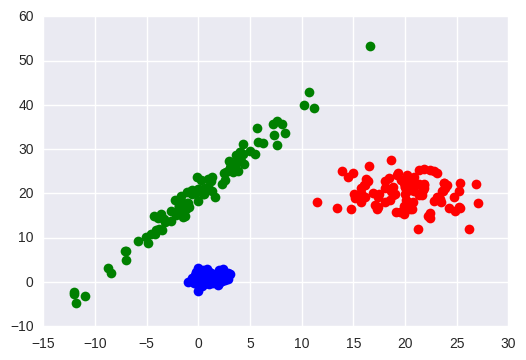

In [3]:
cov = [[1, 0], [0, 1]]
mean = (1, 1)
D1 = np.random.multivariate_normal(mean, cov, 100)

cov = [[10, 0], [0, 10]]
mean = (20, 20)
D2 = np.random.multivariate_normal(mean, cov, 100)

cov = [[50, 100], [0, 1]]
mean = (0, 20)
D3 = np.random.multivariate_normal(mean, cov, 100)

plt.plot(D1[:,0], D1[:,1], 'ob', D2[:,0], D2[:,1], 'or', D3[:,0], D3[:,1], 'og')

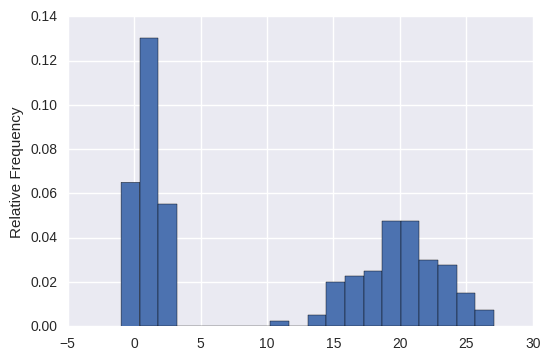

In [4]:
D = np.concatenate((D1, D2))
plt.hist(D[:,0], bins=20, weights=np.zeros_like(D[:,0]) + 1. / D.size)
plt.ylabel('Relative Frequency')

### Exhaustive Algorithm

[       0        1    16383  2375101 42355950]


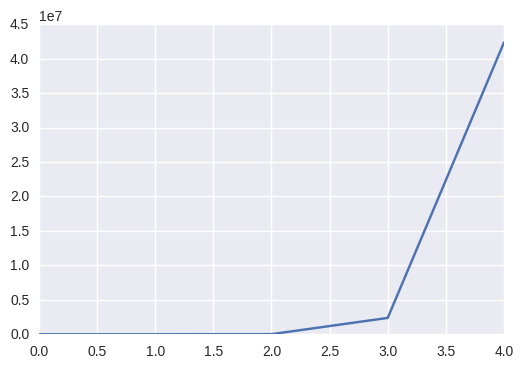

In [5]:
def S(n, k):
    """ Stirling numbers of the second kind """
    assert n >= 0 and k >= 0
    
    if k > n:
        return 0
    
    if n == 0 and k == 0:
        return 1
    
    if k == 0:
        return 0
    
    return k * S(n - 1, k) + S(n - 1, k - 1)

vS = np.vectorize(S)

numbers = vS(15, range(0, 5))

print(numbers)

plt.plot(numbers)

## Representative Clustering

The purpose is to determine a set of $k$ representatives $\*y_1, \ldots, \*y_k$ that minimize the following **objective function** :

$$
\sum_{i = 1}^n \min\{d(\*x_i, \*y_j) : j = 1, \ldots, k\}
$$


### Data Clustering with k-means

#### Generating our data

In [6]:
X, y = sk_data.make_blobs(n_samples=100, centers=3, n_features=2, center_box=(-10.0, 10.0), random_state=0)

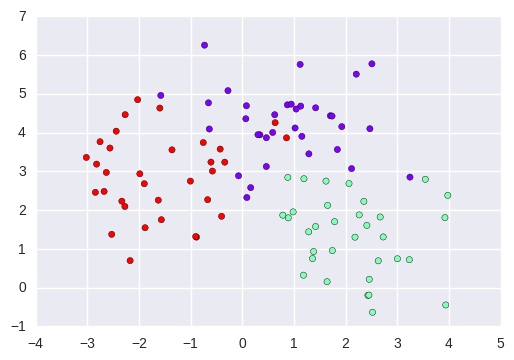

In [7]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.rainbow)

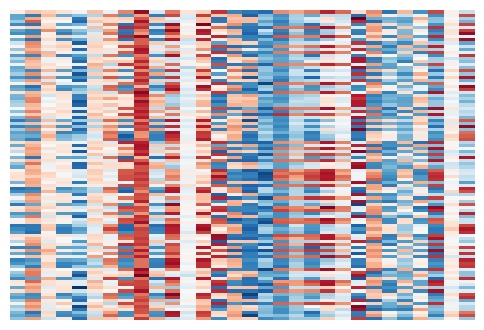

In [8]:
X, y = sk_data.make_blobs(n_samples=100, centers=3, n_features=30, center_box=(-10.0, 10.0), random_state=0)
sns.heatmap(X, xticklabels=False, yticklabels=False, linewidths=0,cbar=False)

**Computing the pairwise distances for visualization purposes**


We can compute pairwise distances using the **sklearn.metrics** functions summarized here:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [9]:
euclidean_dists = metrics.euclidean_distances(X)

Visualizing the data using the heatmap of pairwise distances

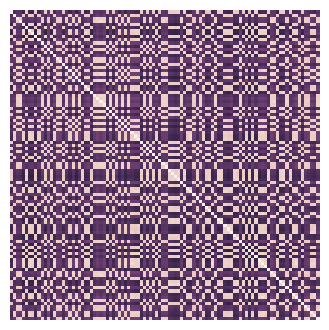

In [10]:
sns.heatmap(euclidean_dists, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=False)

### Clustering data using  k-means clustering in [sklearn.cluster ](http://scikit-learn.org/stable/modules/clustering.html)

In [11]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

print("The total error of the clustering is: ", error)
print('\nCluster labels')
print(labels)
print('\n Cluster Centroids')
print(centroids)


The total error of the clustering is:  2733.8430819

Cluster labels
[1 2 0 0 2 1 2 2 1 2 0 1 0 1 2 0 0 1 0 2 0 2 0 1 2 2 1 0 0 0 0 1 0 1 0 2 0
 2 0 2 2 2 1 0 1 0 1 2 1 0 0 1 1 1 1 0 1 2 2 0 1 0 2 1 1 2 0 1 1 2 2 2 1 1
 0 1 2 1 2 1 2 2 2 1 0 0 2 1 1 0 1 2 2 0 1 0 0 2 2 0]

 Cluster Centroids
[[-4.7833887   5.32946939 -0.87141823  1.38900567 -9.59956915  2.35207348
   2.22988468  2.03394692  8.9797878   3.67857655 -2.67618716 -1.17595897
   3.76433199 -8.46317271  3.28114395  3.73803392 -5.73436869 -7.0844462
  -3.75643598 -3.07904369  1.36974653 -0.95918462  9.91135428 -8.17722281
  -5.8656831  -6.76869078  3.12196673 -4.85745245 -0.70449349 -4.94582258]
 [ 0.88697885  4.29142902  1.93200132  1.10877989 -1.55994342  2.80616392
  -1.11495818  7.74595341  8.92512875 -2.29656298  6.09588722  0.47062896
   1.36408008  8.63168509 -8.54512921 -8.59161818 -9.64308952  6.92270491
   5.65321496  7.29061444  9.58822315  5.79602014 -0.84970449  5.46127493
  -7.77730238  2.75092191 -7.17026663  9.0

There are 3 functions in all the clustering classes, **fit()** **predict()** and **fit_predict()** :

* **fit()** is building the model from the training data (e.g. finding the centroids),             
* **predict()** is assigning labels to test data after building the model,           
* **fit_predict()** is doing both in the same data (e.g in kmeans, it finds the centroids and assigns the labels to the dataset)

### Visualizing the results of clustering

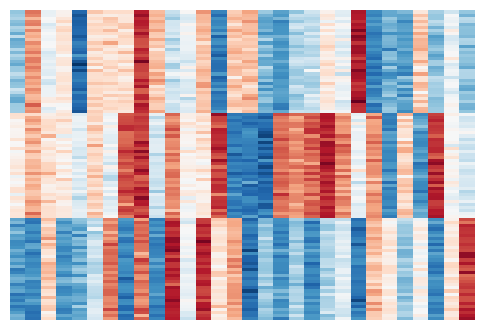

In [12]:
# print original and cluster data
idx = np.argsort(labels)
rX = X[idx,:]
sns.heatmap(rX, xticklabels=False, yticklabels=False, linewidths=0, cbar=False)

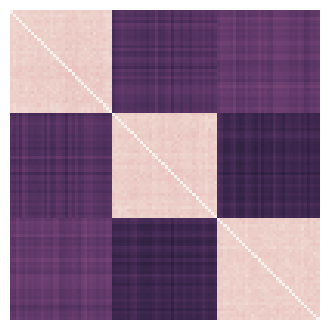

In [13]:
#Rearrange so that all same labels are consecutive

rearranged_dists = euclidean_dists[idx,:][:,idx]
sns.heatmap(rearranged_dists, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=False)

## Deciding the number of clusters

### Using the error function

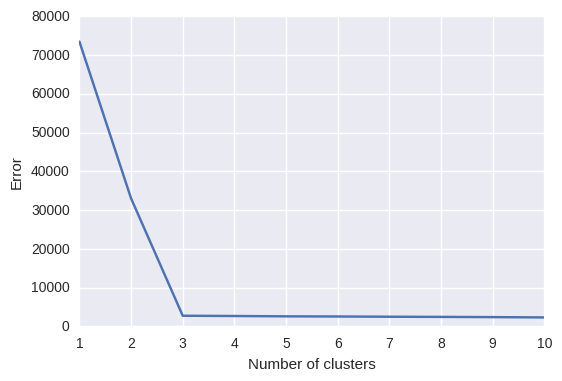

In [14]:
error = np.zeros(11)
error[0] = 0
for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X)
    error[k] = kmeans.inertia_

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

Making this a function :

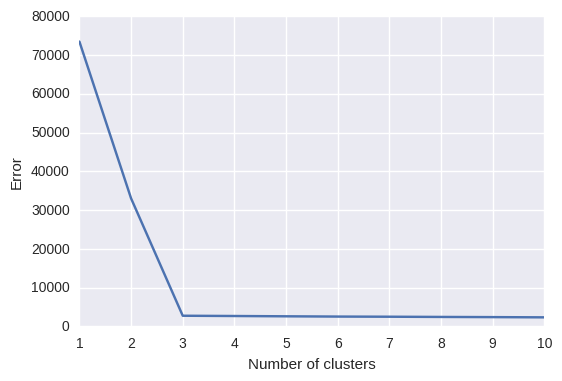

In [15]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

evaluate_clusters(X,10)

### Silhouette Coefficient

Let $a$ be the mean distance between a sample and all other points in the same class and $b$ be the mean distance between a sample and all other points in the next nearest cluster. Then the 
**Silhoeutte Coefficient** for a clustering is:
$$s = \frac{b - a}{\max(a, b)}$$

In [17]:
sc = metrics.silhouette_score(X, labels, metric='euclidean')
print(sc)

0.83193488414


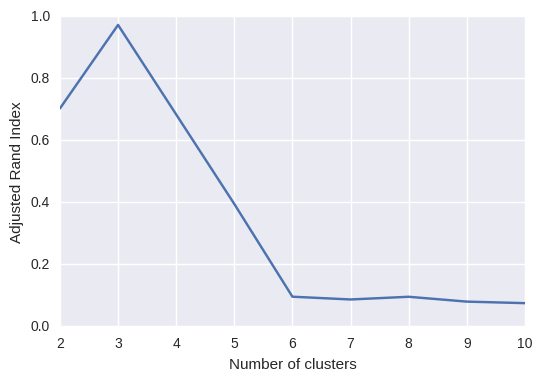

In [18]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    
sc_evaluate_clusters(X,10)

## References

This notebook is based on [Boston University CS591 "Tools and Techniques for Data Mining and Applications" course](https://github.com/dataminingapp/dataminingapp-lectures) and on the following books :

* [Zaki, 2014] *Data Mining and Analysis: Fundamental Concepts and Algorithms*, by Mohammed J. Zaki and Wagner Meira : Chapters 13, 14, and 17
* [Aggarwal, 2015] *Data Mining : The Textbook*, by Charu C. Aggarwal : Chapters 1 and 6 